# 로이터 뉴스 분류하기(Reuters News Classification)
*  LSTM을 이용하여 텍스트 분류
* 다중 클래스 분류 문제
* 총 11,258개의 뉴스 기사 / 46개의 뉴스 카테고리
* 데이터는 토큰화와 정수인코딩이 끝난 상태
* 정수 인코딩은 단어의 등장빈도 순서로 인덱스 부여됨

### Data Load & Preprocessing

In [1]:
from tensorflow.keras.datasets import reuters
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# train test split
# num_words : 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절
# 100이란 값을 넣으면, 등장 빈도 순위가 1~100에 해당하는 단어만 사용
# 모든 단어를 사용하고자 한다면 None
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


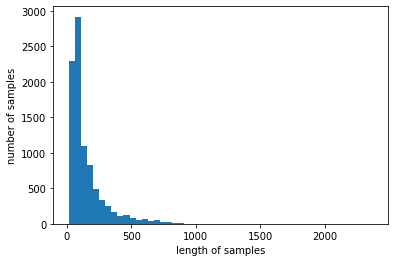

In [4]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


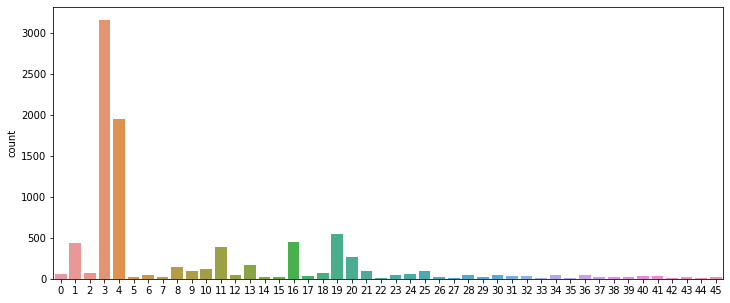

In [5]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [6]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
label_cnt=dict(zip(unique_elements, counts_elements))
print("각 레이블에 대한 빈도수:")
print(label_cnt)

각 레이블에 대한 빈도수:
{0: 55, 1: 432, 2: 74, 3: 3159, 4: 1949, 5: 17, 6: 48, 7: 16, 8: 139, 9: 101, 10: 124, 11: 390, 12: 49, 13: 172, 14: 26, 15: 20, 16: 444, 17: 39, 18: 66, 19: 549, 20: 269, 21: 100, 22: 15, 23: 41, 24: 62, 25: 92, 26: 24, 27: 15, 28: 48, 29: 19, 30: 45, 31: 39, 32: 32, 33: 11, 34: 50, 35: 10, 36: 49, 37: 19, 38: 19, 39: 24, 40: 36, 41: 30, 42: 13, 43: 21, 44: 12, 45: 18}


### LSTM Model

In [7]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [22]:
# 학습에서는 등장 빈도 순서가 가장 많은 상위 1 ~ 1,000번째인 단어들만 사용
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [23]:
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 뉴스 기사 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 뉴스 기사 패딩

In [25]:
# 다중 클래스 분류이므로 원-핫 인코딩
y_train = to_categorical(y_train) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 뉴스 기사 레이블의 원-핫 인코딩

In [31]:
# 위에서 num_words=1000으로 설정했으므로 Embedding시 단어 집합 사이즈도 1000
model = Sequential()
model.add(Embedding(1000, 120))
model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))

In [32]:
# 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [33]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [34]:
# training
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
71/71 [==============================] - 29s 382ms/step - loss: 2.9787 - acc: 0.3247 - val_loss: 2.4095 - val_acc: 0.3620

Epoch 00001: val_acc improved from -inf to 0.36198, saving model to best_model.h5
Epoch 2/30
71/71 [==============================] - 26s 361ms/step - loss: 2.2717 - acc: 0.3985 - val_loss: 2.0057 - val_acc: 0.5076

Epoch 00002: val_acc improved from 0.36198 to 0.50757, saving model to best_model.h5
Epoch 3/30
71/71 [==============================] - 26s 370ms/step - loss: 1.9628 - acc: 0.4961 - val_loss: 1.7695 - val_acc: 0.5459

Epoch 00003: val_acc improved from 0.50757 to 0.54586, saving model to best_model.h5
Epoch 4/30
71/71 [==============================] - 25s 350ms/step - loss: 1.7226 - acc: 0.5528 - val_loss: 1.7273 - val_acc: 0.5570

Epoch 00004: val_acc improved from 0.54586 to 0.55699, saving model to best_model.h5
Epoch 5/30
71/71 [==============================] - 24s 340ms/step - loss: 1.6704 - acc: 0.5668 - val_loss: 1.7235 - val_acc: 0

In [36]:
# 훈련 과정에서 검증 데이터가 가장 높았을 때 저장된 모델인 'best_model.h5'를 로드하고, 성능을 평가
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 3s 30ms/step - loss: 1.1729 - acc: 0.7235

 테스트 정확도: 0.7235


**주희 사항**
* 이번 모델은 검증 데이터와 테스트 데이터가 동일함 (validation_data 도 X_test,y_test이고 evaluate할 때도 사용)
* 케라스의 model.fit()에서 validation_data는 실제 기계가 데이터를 훈련하지는 않고 에포크마다 정확도와 loss를 출력하여 과적합을 판단하기 위한 용도로만 사용되기 때문에 model.evaluate()에서도 다시 사용함
* 하지만 데이터가 충분하다면, 검증 데이터와 테스트 데이터는 다르게 사용하는 것이 좋음

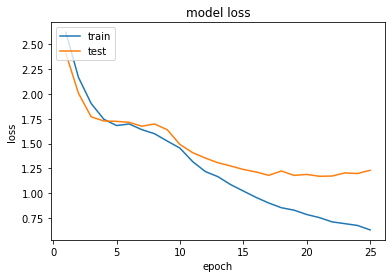

In [37]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()